In [1]:
import pandas as pd
import numpy as np
from altair_saver import save
import altair as alt
import altair_saver
from IPython.display import Image

## Data Ingestion

In [2]:
df = pd.read_csv('../data_mturk_espanol/Emotion Survey - Free responses - Español_March 28, 2022_15.59.csv')
df_label = pd.read_csv('../data_mturk_espanol/emotion_labels_espanol.csv')
df_reject = pd.read_csv('../data_mturk_espanol/free_choice_mturk_rejections_espanol.csv')

In [3]:
df_label['url'] = df_label['url'].astype(str)

In [4]:
df_label.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194 entries, 0 to 193
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ethnicity  192 non-null    object
 1   sex        192 non-null    object
 2   age        192 non-null    object
 3   label      194 non-null    object
 4   url        194 non-null    object
 5   photoId    194 non-null    object
dtypes: object(6)
memory usage: 9.2+ KB


In [5]:
# replicate rows by 4 to match with free responses lenght
df_labels = pd.DataFrame(np.repeat(df_label.values, 4, axis=0))
df_labels.columns = df_label.columns

# add photo id col
df_labels['photoId'] = df.loc[:, 'Q2.1_1':'Q195.1_4'].columns

In [6]:
df_labels.to_csv('../data_mturk_espanol/emotion_labels_free_choice_mturk_espanol.csv', index=False)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Columns: 804 entries, StartDate to random
dtypes: object(804)
memory usage: 904.6+ KB


In [8]:
df = df[~df['ResponseId'].isin(df_reject['ResponseId'].astype('str'))] # filter out rejected surveys
df = df[df['Finished'] =='True'] # filter out incomplete surveys
df = df[df['Duration (in seconds)'].astype(int) > 600] # filter out surveys < 10 minutes duration

In [9]:
# df = df.iloc[3:, :] # filter metadata rows

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33 entries, 4 to 143
Columns: 804 entries, StartDate to random
dtypes: object(804)
memory usage: 207.5+ KB


In [11]:
df.rename(columns={
    'Q1.2': 'sex',
    'Q1.3_1': 'age',
    'Q1.4': 'ethnicity',
    'Q1.5': 'formal education',
    'Q1.6_1': 'income',
    'Q1.7': 'country'}, inplace=True)

In [12]:
df.to_csv('../clean_data_mturk_espanol/free_choice_emotion_mturk_espanol.csv', index=False)

In [13]:
# placeholders to save svg strings
svg_str = []
image_title = []

In [14]:
def count_freq_labels(df, X="all", col=None):
    """Returns the frequency and percent of each emotion category in the survey 
    
    Arguments:
    
    df -- dataframe 
    X  -- whether to use all participants, or a subgroup
    """
    
    if X == "all":
        df_counts = df.stack().reset_index(drop=True).value_counts() # stack as series
        df_counts = df_counts.to_frame('counts') # get value_counts as df
        df_counts['emotion'] = df_counts.index # get index as col
    elif X == "stacked":
        df_counts = df[col].value_counts() # count word frequency
        df_counts = df_counts.to_frame('counts') # get value_counts as df
        df_counts['emotion'] = df_counts.index # get index as col    
    else:
        df_counts = df[X].reset_index(drop=True).value_counts() # stack as series
        df_counts = df_counts.to_frame('counts') # get value_counts as df
        df_counts[X] = df_counts.index # get index as col

    df_counts = df_counts.reset_index(drop=True) # clean index
    df_counts['percent'] = df_counts['counts'] / df_counts['counts'].sum() # compute percentage
    
    return df_counts

In [15]:
def simple_per_bar(
    df, title='Title', X='percent:Q', Y='emotion:N', \
    width=450, height=250, sort='-x', \
    text_size = 12, label_size = 11, title_size=12, \
    emotion=None, color1='#0570b0', color2='orange'):
    
    """Returns percentage bars by emotion category"""
    
    bars = alt.Chart(df, title=title).mark_bar().encode(
        alt.X(X, axis=alt.Axis(format='.0%')),
        y=alt.Y(Y, sort=sort), 
        color=alt.condition(
            alt.datum.emotion == emotion,
            alt.value(color2),
            alt.value(color1)
        ))
    
    text = bars.mark_text(
    align='left',
    baseline='middle',
    dx=3,  # Nudges text to right so it doesn't appear on top of the bar
    fontSize=text_size
    ).encode(
        alt.Text(X, format='.1%')
    )
    
    chart = (bars + text).configure_axis(
            labelFontSize=label_size,
            titleFontSize=title_size).properties(
                width=width, 
                height=height)
    
    
    return chart

In [16]:
def simple_per_bar_concat(
    df, title='Title', X='percent:Q', Y='emotion:N',\
    sort='-x', text_size = 12, emotion=None,\
    color1='#0570b0', color2='orange'):
    
    """Returns percentage bars by emotion category for concatenation"""

    bars = alt.Chart(df, title=title).mark_bar().encode(
        alt.X(X, axis=alt.Axis(format='.0%')),
        y=alt.Y(Y, sort=sort), 
        color=alt.condition(
            alt.datum.emotion == emotion,
            alt.value(color2),
            alt.value(color1)
        ))
    
    text = bars.mark_text(
    align='left',
    baseline='middle',
    dx=3,  # Nudges text to right so it doesn't appear on top of the bar
    fontSize=text_size
    ).encode(
        alt.Text(X, format='.1%')
    )
    
    chart = (bars + text)
    
    return chart

In [17]:
def simple_count_bar(
    df, title='Title', X='counts:Q', Y='emotion:N', \
    width=450, height=250, sort='-x', \
    text_size = 12, label_size = 11, title_size=12,
    emotion=None, color1='#0570b0', color2='#orange'):

    """Return percentage bars by emotion category for concatenation"""

    
    bars = alt.Chart(df, title=title).mark_bar().encode(
        alt.X(X),
        y=alt.Y(Y, sort=sort), 
        color=alt.condition(
            alt.datum.emotion == emotion,
            alt.value(color2),
            alt.value(color1)
        ))
    
    text = bars.mark_text(
    align='left',
    baseline='middle',
    dx=3,  # Nudges text to right so it doesn't appear on top of the bar
    fontSize=text_size
    ).encode(
        alt.Text(X)
    )
    
    chart = (bars + text).configure_axis(
            labelFontSize=label_size,
            titleFontSize=title_size).properties(
                width=width, 
                height=height)
    
    
    return chart

## Demographics

In [18]:
source = count_freq_labels(df, X="sex") 
title = 'Sex | n = '+ source['counts'].sum().astype(str)
X, Y = 'percent:Q', 'sex:N'
w, h= 450, 150
txs, ls, ts = 12, 12, 12

chart_sex = simple_per_bar(
    source, title=title, X=X, Y=Y, \
    width=w, height=h, \
    text_size = txs, label_size = ls, title_size=ts)

chart_sex.display(renderer='svg')

alt.LayerChart(...)

In [19]:
chart_sex_string = altair_saver.save(chart_sex, fmt='svg')
image_title.append('Participants by sex')
svg_str.append(chart_sex_string)

In [20]:
source = count_freq_labels(df, X="age") 
n_sample = source['counts'].sum().astype(str)

# binning age for chart
bins = [20, 30, 40, 50, 60]
source['age bins'] = pd.cut(source['age'].astype(int), bins)
source = source.groupby(['age bins'])['percent'].sum().to_frame().reset_index()
source['age bins'] = source['age bins'].astype(str)

title = 'Age | n = '+ n_sample
X, Y = 'percent:Q', 'age bins:N'
w, h= 450, 150
txs, ls, ts = 12, 12, 12

chart_age = simple_per_bar(
    source, title=title, X=X, Y=Y, \
    width=w, height=h, \
    text_size = txs, label_size = ls, title_size=ts)

chart_age.display(renderer='svg')

alt.LayerChart(...)

In [21]:
chart_age_str = altair_saver.save(chart_age, fmt='svg')
image_title.append('Participants by age')
svg_str.append(chart_age_str)

In [22]:
source = count_freq_labels(df, X="ethnicity") 
title = 'Ethnicity | n = '+ source['counts'].sum().astype(str)
X, Y = 'percent:Q', 'ethnicity:N'
w, h= 450, 150
txs, ls, ts = 12, 11, 12

chart_ethnicity= simple_per_bar(
    source, title=title, X=X, Y=Y, \
    width=w, height=h, \
    text_size = txs, label_size = ls, title_size=ts)
chart_ethnicity.display(renderer='svg')

alt.LayerChart(...)

In [23]:
chart_et_str = altair_saver.save(chart_ethnicity, fmt='svg')
image_title.append('Participants by ethnicity')
svg_str.append(chart_et_str)

In [24]:
source = count_freq_labels(df, X="formal education") 
title = 'Formal education | n = '+ source['counts'].sum().astype(str)
X, Y = 'percent:Q', 'formal education:N'
w, h= 450, 150
txs, ls, ts = 12, 11, 12

chart_formal_education= simple_per_bar(
    source, title=title, X=X, Y=Y,\
    width=w, height=h, \
    text_size = txs, label_size = ls, title_size=ts)
chart_formal_education.display(renderer='svg')

alt.LayerChart(...)

In [25]:
chart_formal_education_str = altair_saver.save(chart_formal_education, fmt='svg')
image_title.append('Participants by formal education')
svg_str.append(chart_formal_education_str)

In [26]:
## clean up country
df['country'] = df['country'].str.lower()
df['country'] = df['country'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

df['country'].replace(['venezolano', 'venezolana'], 'venezuela', inplace=True)
df['country'].replace(['colombiano', 'colombiana'], 'colombia', inplace=True)
df['country'].replace(['mexicano', 'mexicana'], 'mexico', inplace=True)
df['country'].replace(['ecuatoriano', 'ecuatoriano'], 'ecuador', inplace=True)
df['country'].replace(['argentino'], 'argentina', inplace=True)

In [27]:
source = count_freq_labels(df, X="country") 
title = 'Country of origin | n = '+ source['counts'].sum().astype(str)
X, Y = 'percent:Q', 'country:N'
w, h= 450, 150
txs, ls, ts = 12, 10, 12

chart_country= simple_per_bar(
    source, title=title, X=X, Y=Y,\
    width=w, height=h, \
    text_size = txs, label_size = ls, title_size=ts)
chart_country.display(renderer='svg')

alt.LayerChart(...)

In [28]:
chart_country_str = altair_saver.save(chart_country, fmt='svg')
image_title.append('Participants by country of origin')
svg_str.append(chart_country_str)

## Formating

In [29]:
df_emo_answers = df.loc[:, 'Q2.1_1':'Q195.1_4'] # get cols with words only

## Manual word clean up

In [30]:
def formating_words(df, len_words=1, len_letters=2):
    df_stack = df.stack().reset_index(drop=True) # stack as series
    df_stack = df_stack.to_frame(name='emotion') # as DF
    df_stack['emotion'] = df_stack['emotion'].str.strip() # remove blank spaces
    df_stack['emotion'] = df_stack['emotion'].str.lower() # as lower case
    df_stack['emotion'] = df_stack['emotion'].replace({'na':'none'}) 
    df_stack['len_words'] = df_stack['emotion'].str.split().apply(len) # cnt number of words
    df_stack['len_letters'] = df_stack['emotion'].apply(len) # cont number of letters
    # get df with single words of 3 or more letters
    df_stack_single_word = df_stack[(df_stack['len_words'] == len_words) & (df_stack['len_letters'] > len_letters)] 
    
    return df_stack_single_word

In [31]:
df_stack_single_word = formating_words(df_emo_answers)

In [32]:
free_choice_word_list = count_freq_labels(df_stack_single_word, 'emotion')['emotion']

In [33]:
free_choice_word_list.to_csv('../clean_data_mturk_espanol/free_choice_word_list_mturk_espanol.csv', index=False)

In [34]:
# word clean up
def manual_replace(df_stack):
    """manual replacement of mispelled words"""
    
    df_stack.replace(['feliz', 'felicidad', 'feliidad'], 'felicidad', inplace=True)
    
    df_stack.replace(['enojo', 'enojado', 'enojada', 'enfadado', 'enfadada', 'enfado'], 'enfado', inplace=True)
    
    df_stack.replace(['tristeza', 'triste', 'trite'], 'tristeza', inplace=True)
    
    df_stack.replace(['aasco', 'asqueado', 'asqueada'], 'asco', inplace=True)
    
    df_stack.replace(['sorprendido', 'sorprendida', 'sorpresa', 'sorpreda', 'sorepresa'], 'sorpresa', inplace=True)
    
    df_stack.replace(['miedoso', 'miedosa', 'miedo'], 'miedo', inplace=True)

    df_stack.replace(['molesta', 'molesto', 'molestoso', 'molestada', 'molestado'], 'molesto', inplace=True)

    df_stack.replace(['neutralidad', 'neutral'], 'neutral', inplace=True)
    
    return df_stack
    

In [35]:
df_stack_single_word = manual_replace(df_stack_single_word)


## Steamming


In [36]:
from nltk.stem import SnowballStemmer

In [37]:
snowball = SnowballStemmer('spanish')

# Snowball stemmer
df_stack_single_word['emotion_sb_steamed'] = df_stack_single_word['emotion'].apply(lambda x: snowball.stem(x))

## Count frequency and plot

In [38]:
df_emo_overall = count_freq_labels(df_stack_single_word, X="stacked", col='emotion_sb_steamed')

In [39]:
source = df_emo_overall[df_emo_overall['counts'] > 50]
title = 'Labels with 50 or more mentions (steamed) | n = '+ source['counts'].sum().astype(str)
X, Y = 'percent:Q', 'emotion:N'
w, h= 450, 600
txs, ls, ts = 12, 11, 12

chart_overall_per = simple_per_bar(source, title=title, X=X, Y=Y, width=w, height=h, text_size = txs, label_size = ls, title_size=ts)
chart_overall_per.display(renderer='svg')

alt.LayerChart(...)

In [40]:
chart_overall_per_str = altair_saver.save(chart_overall_per, fmt='svg')
image_title.append('Overall results by expected label as %')
svg_str.append(chart_overall_per_str)

In [41]:
source = df_emo_overall[df_emo_overall['counts'] > 49]
title = 'Labels with 50 or more mentions (steamed) | n = '+ source['counts'].sum().astype(str)
X, Y = 'counts:Q', 'emotion:N'
w, h= 450, 600
txs, ls, ts = 12, 11, 12

chart_overall_count = simple_count_bar(source, title=title, X=X, Y=Y, width=w, height=h, text_size = txs, label_size = ls, title_size=ts)
chart_overall_count.display(renderer='svg')

alt.LayerChart(...)

In [42]:
chart_overall_count_str = altair_saver.save(chart_overall_count, fmt='svg')
image_title.append('Overall results by expected label as count')
svg_str.append(chart_overall_count_str)

## Most frequently used word for each emotion category (grouping pictures by expected-emotion)

In [43]:
def emotion_df_formated(df_emo_answers, emotion_label):
    df_emo_cat = df_emo_answers.copy() 
    df_emo_cat_t = df_emo_cat.T # transpose
    df_emo_cat_t['photo_id'] = df_emo_cat_t.index # get index as col
    df_emo_cat_t = df_emo_cat_t.reset_index(drop=True) # clean index
    df_emo_cat_t_labels = pd.concat([df_emo_cat_t, df_labels], axis=1) # add metadata cols
    df_label =  df_emo_cat_t_labels[df_emo_cat_t_labels['label'] == emotion_label]
    
    return df_label

### Anger

In [44]:
emotion = 'enfado'
emotion_st = 'enfad'
df_emotion = emotion_df_formated(df_emo_answers, emotion) # subset 'emotion' rows
df_emotion_ans = df_emotion.drop(['photo_id', 'ethnicity', 'sex','age', 'label', 'url', 'photoId'], axis=1)
df_stack_emotion = formating_words(df_emotion_ans) # clean up
df_stack_emotion = manual_replace(df_stack_emotion) # fix misspelling
df_stack_emotion['emotion_sb_steamed'] = df_stack_emotion['emotion'].apply(lambda x: snowball.stem(x))#steam
source = count_freq_labels(df_stack_emotion, X='stacked', col='emotion_sb_steamed')
source_10 = source[source['counts'] > 10]

title = 'Expcted label: '+ emotion + ' | Labels with 10 or more mentions | n = '+ source['counts'].sum().astype(str)
X, Y = 'percent:Q', 'emotion:N'
w, h= 450, 600
txs, ls, ts = 12, 11, 12


chart_anger = simple_per_bar(
    source_10, title=title, X=X, Y=Y, \
    width=w, height=h, emotion=emotion_st, \
    text_size = txs, label_size = ls, title_size=ts)
chart_anger.display(renderer='svg')

alt.LayerChart(...)

In [45]:
chart_anger_str = altair_saver.save(chart_anger, fmt='svg')
image_title.append("Images depicting 'anger'")
svg_str.append(chart_anger_str)

### Disgust

In [46]:
emotion = 'asco'
emotion_st = 'asco'
df_emotion = emotion_df_formated(df_emo_answers, emotion) # subset 'emotion' rows
df_emotion_ans = df_emotion.drop(['photo_id', 'ethnicity', 'sex','age', 'label', 'url', 'photoId'], axis=1)
df_stack_emotion = formating_words(df_emotion_ans) # clean up
df_stack_emotion = manual_replace(df_stack_emotion) # fix misspelling
df_stack_emotion['emotion_sb_steamed'] = df_stack_emotion['emotion'].apply(lambda x: snowball.stem(x))#steam
source = count_freq_labels(df_stack_emotion,X='stacked', col='emotion_sb_steamed')
source_10 = source[source['counts'] > 10]

title = 'Expcted label: '+ emotion + ' | Labels with 10 or more mentions | n = '+ source['counts'].sum().astype(str)
X, Y = 'percent:Q', 'emotion:N'
w, h= 450, 600
txs, ls, ts = 12, 11, 12


chart_disgust = simple_per_bar(
    source_10, title=title, X=X, Y=Y, \
    width=w, height=h, emotion=emotion_st, \
    text_size = txs, label_size = ls, title_size=ts)
chart_disgust.display(renderer='svg')

alt.LayerChart(...)

In [47]:
chart_disgust_str = altair_saver.save(chart_disgust, fmt='svg')
image_title.append("Images depicting 'disgust'")
svg_str.append(chart_disgust_str)

### Fear

In [48]:
emotion = 'miedo'
emotion_st = 'mied'
df_emotion = emotion_df_formated(df_emo_answers, emotion) # subset 'emotion' rows
df_emotion_ans = df_emotion.drop(['photo_id', 'ethnicity', 'sex','age', 'label', 'url', 'photoId'], axis=1)
df_stack_emotion = formating_words(df_emotion_ans) # clean up
df_stack_emotion = manual_replace(df_stack_emotion) # fix misspelling
df_stack_emotion['emotion_sb_steamed'] = df_stack_emotion['emotion'].apply(lambda x: snowball.stem(x))#steam
source = count_freq_labels(df_stack_emotion,X='stacked', col='emotion_sb_steamed')
source_10 = source[source['counts'] > 10]

title = 'Expcted label: '+ emotion + ' | Labels with 10 or more mentions | n = '+ source['counts'].sum().astype(str)
X, Y = 'percent:Q', 'emotion:N'
w, h= 450, 600
txs, ls, ts = 12, 11, 12


chart_fear = simple_per_bar(
    source_10, title=title, X=X, Y=Y, \
    width=w, height=h, emotion=emotion_st, \
    text_size = txs, label_size = ls, title_size=ts)
chart_fear.display(renderer='svg')

alt.LayerChart(...)

In [49]:
chart_fear_str = altair_saver.save(chart_fear, fmt='svg')
image_title.append("Images depicting 'fear'")
svg_str.append(chart_fear_str)

### Surprise

In [50]:
emotion = 'sorpresa'
emotion_st = 'sorpres'
df_emotion = emotion_df_formated(df_emo_answers, emotion) # subset 'emotion' rows
df_emotion_ans = df_emotion.drop(['photo_id', 'ethnicity', 'sex','age', 'label', 'url', 'photoId'], axis=1)
df_stack_emotion = formating_words(df_emotion_ans) # clean up
df_stack_emotion = manual_replace(df_stack_emotion) # fix misspelling
df_stack_emotion['emotion_sb_steamed'] = df_stack_emotion['emotion'].apply(lambda x: snowball.stem(x))#steam
source = count_freq_labels(df_stack_emotion,X='stacked', col='emotion_sb_steamed')
source_10 = source[source['counts'] > 10]

title = 'Expcted label: '+ emotion + ' | Labels with 10 or more mentions | n = '+ source['counts'].sum().astype(str)
X, Y = 'percent:Q', 'emotion:N'
w, h= 450, 600
txs, ls, ts = 12, 11, 12


chart_surprise = simple_per_bar(
    source_10, title=title, X=X, Y=Y, \
    width=w, height=h, emotion=emotion_st, \
    text_size = txs, label_size = ls, title_size=ts)
chart_surprise.display(renderer='svg')

alt.LayerChart(...)

In [51]:
chart_surprise_str = altair_saver.save(chart_surprise, fmt='svg')
image_title.append("Images depicting 'surprise'")
svg_str.append(chart_surprise_str)

### Happiness

In [52]:
emotion = 'felicidad'
emotion_st = 'felic'
df_emotion = emotion_df_formated(df_emo_answers, emotion) # subset 'emotion' rows
df_emotion_ans = df_emotion.drop(['photo_id', 'ethnicity', 'sex','age', 'label', 'url', 'photoId'], axis=1)
df_stack_emotion = formating_words(df_emotion_ans) # clean up
df_stack_emotion = manual_replace(df_stack_emotion) # fix misspelling
df_stack_emotion['emotion_sb_steamed'] = df_stack_emotion['emotion'].apply(lambda x: snowball.stem(x))#steam
source = count_freq_labels(df_stack_emotion,X='stacked', col='emotion_sb_steamed')

source_10 = source[source['counts'] > 10]

title = 'Expcted label: '+ emotion + ' | Labels with 10 or more mentions | n = '+ source['counts'].sum().astype(str)
X, Y = 'percent:Q', 'emotion:N'
w, h= 450, 600
txs, ls, ts = 12, 11, 12


chart_happiness = simple_per_bar(
    source_10, title=title, X=X, Y=Y, \
    width=w, height=h, emotion=emotion_st, \
    text_size = txs, label_size = ls, title_size=ts)
chart_happiness.display(renderer='svg')

alt.LayerChart(...)

In [53]:
chart_happiness_str = altair_saver.save(chart_happiness, fmt='svg')
image_title.append("Images depicting 'happiness'")
svg_str.append(chart_happiness_str)

### Sadness

In [54]:
emotion = 'tristeza'
emotion_st = 'tristez'
df_emotion = emotion_df_formated(df_emo_answers, emotion) # subset 'emotion' rows
df_emotion_ans = df_emotion.drop(['photo_id', 'ethnicity', 'sex','age', 'label', 'url', 'photoId'], axis=1)
df_stack_emotion = formating_words(df_emotion_ans) # clean up
df_stack_emotion = manual_replace(df_stack_emotion) # fix misspelling
df_stack_emotion['emotion_sb_steamed'] = df_stack_emotion['emotion'].apply(lambda x: snowball.stem(x))#steam
source = count_freq_labels(df_stack_emotion,X='stacked', col='emotion_sb_steamed')
source_10 = source[source['counts'] > 10]

title = 'Expcted label: '+ emotion + ' | Labels with 10 or more mentions | n = '+ source['counts'].sum().astype(str)
X, Y = 'percent:Q', 'emotion:N'
w, h= 450, 600
txs, ls, ts = 12, 11, 12


chart_sadness = simple_per_bar(
    source_10, title=title, X=X, Y=Y, \
    width=w, height=h, emotion=emotion_st, \
    text_size = txs, label_size = ls, title_size=ts)
chart_sadness.display(renderer='svg')

alt.LayerChart(...)

In [55]:
chart_sadness_str = altair_saver.save(chart_sadness, fmt='svg')
image_title.append("Images depicting 'sadness'")
svg_str.append(chart_sadness_str)

### Uncertain

In [56]:
emotion = 'incertidumbre'
emotion_st = 'incertidumbre'
df_emotion = emotion_df_formated(df_emo_answers, emotion) # subset 'emotion' rows
df_emotion_ans = df_emotion.drop(['photo_id', 'ethnicity', 'sex','age', 'label', 'url', 'photoId'], axis=1)
df_stack_emotion = formating_words(df_emotion_ans) # clean up
df_stack_emotion = manual_replace(df_stack_emotion) # fix misspelling
df_stack_emotion['emotion_sb_steamed'] = df_stack_emotion['emotion'].apply(lambda x: snowball.stem(x))#steam
source = count_freq_labels(df_stack_emotion,X='stacked', col='emotion_sb_steamed')

source_10 = source[source['counts'] > 10]

title = 'Expcted label: '+ emotion + ' | Labels with 10 or more mentions | n = '+ source['counts'].sum().astype(str)
X, Y = 'percent:Q', 'emotion:N'
w, h= 450, 600
txs, ls, ts = 12, 11, 12


chart_uncertain = simple_per_bar(
    source_10, title=title, X=X, Y=Y, \
    width=w, height=h, emotion=emotion_st, \
    text_size = txs, label_size = ls, title_size=ts)
chart_uncertain.display(renderer='svg')

alt.LayerChart(...)

In [57]:
chart_uncertain_str = altair_saver.save(chart_uncertain, fmt='svg')
image_title.append("Images depicting 'uncertain (unknown)'")
svg_str.append(chart_uncertain_str)

### Neutral

In [58]:
emotion = 'neutral'
emotion_st = 'neutral'
df_emotion = emotion_df_formated(df_emo_answers, emotion) # subset 'emotion' rows
df_emotion_ans = df_emotion.drop(['photo_id', 'ethnicity', 'sex','age', 'label', 'url', 'photoId'], axis=1)
df_stack_emotion = formating_words(df_emotion_ans) # clean up
df_stack_emotion = manual_replace(df_stack_emotion) # fix misspelling
df_stack_emotion['emotion_sb_steamed'] = df_stack_emotion['emotion'].apply(lambda x: snowball.stem(x))#steam
source = count_freq_labels(df_stack_emotion,X='stacked', col='emotion_sb_steamed')
source_10 = source[source['counts'] > 10]

title = 'Expcted label: '+ emotion + ' | Labels with 10 or more mentions | n = '+ source['counts'].sum().astype(str)
X, Y = 'percent:Q', 'emotion:N'
w, h= 450, 600
txs, ls, ts = 12, 11, 12


chart_neutral = simple_per_bar(
    source_10, title=title, X=X, Y=Y, \
    width=w, height=h, emotion=emotion_st, \
    text_size = txs, label_size = ls, title_size=ts)
chart_neutral.display(renderer='svg')

alt.LayerChart(...)

In [59]:
chart_neutral_str = altair_saver.save(chart_neutral, fmt='svg')
image_title.append("Images depicting 'neutral'")
svg_str.append(chart_neutral_str)

## Most frequently used word for each emotion category (grouping pictures by expected-emotion), by ethnicity group

In [60]:
def emotion_df_formated_et(df_emo_answers, emotion_label, ethnicity):
    
    """Returns df with metadata in long format, filtered by emotion and ethnicity
    
    Arguments:
    df_emo_answers -- dataframe with participants answers only
    emotion_label -- emotion label to filter out dataframe
    ethnicity -- ethnicity group to filter our dataframe
    """
    
    df_emo_cat = df_emo_answers.copy() 
    df_emo_cat_t = df_emo_cat.T # transpose
    df_emo_cat_t['photo_id'] = df_emo_cat_t.index # get index as col
    df_emo_cat_t = df_emo_cat_t.reset_index(drop=True) # clean index
    df_emo_cat_t_labels = pd.concat([df_emo_cat_t, df_labels], axis=1) # add metadata cols
    df_label =  df_emo_cat_t_labels[(df_emo_cat_t_labels['label'] == emotion_label) & (df_emo_cat_t_labels['ethnicity'] == ethnicity)]
    
    return df_label

In [61]:
def wrapper_chart_emotion(df_emo_answers, emotion, ethnicity, emotion_st=None, n_mentions=10):

    """Convenience function to generate plots more easily.
    It combines adding metadata, counting, and generetaing charts
    Returns emotion categories percentages for an emotion and ethnicity group"""
    
    df = emotion_df_formated_et(df_emo_answers, emotion,  ethnicity) # subset 'anger' rows
    df_emotion_ans = df.drop(['photo_id', 'ethnicity', 'sex','age', 'label', 'url', 'photoId'], axis=1)
    df_stack_emotion = formating_words(df_emotion_ans) # clean up
    df_stack_emotion = manual_replace(df_stack_emotion) # fix misspelling
    df_stack_emotion['emotion_sb_steamed'] = df_stack_emotion['emotion'].apply(lambda x: snowball.stem(x))#steam
    df_count = count_freq_labels(df_stack_emotion,X='stacked', col='emotion_sb_steamed')
    source = df_count[df_count['counts'] >= n_mentions]

    chart = simple_per_bar_concat(
        source, \
        title=f"Expected label: {emotion} | Labels with {n_mentions} or more mentions | n= {source['counts'].sum().astype(str)}", \
        emotion=emotion_st)
    
    return chart

### Anger

In [62]:
chart_anger_bipoc = wrapper_chart_emotion(df_emo_answers, 'enfado', 'bipoc', emotion_st='enfad', n_mentions=10)
chart_anger_white = wrapper_chart_emotion(df_emo_answers, 'enfado', 'white', emotion_st='enfad', n_mentions=10)

chart_anger_layered =  (chart_anger_bipoc | chart_anger_white)

chart_anger_layered.display(renderer='svg')

alt.HConcatChart(...)

In [63]:
chart_anger_layered_str = altair_saver.save(chart_anger_layered, fmt='svg')
image_title.append("'anger' by ethnicity")
svg_str.append(chart_anger_layered_str)

### Disgust

In [64]:
chart_disgust_bipoc = wrapper_chart_emotion(df_emo_answers, 'asco', 'bipoc', emotion_st='asco', n_mentions=10)
chart_disgust_white = wrapper_chart_emotion(df_emo_answers, 'asco', 'white', emotion_st='asco', n_mentions=10)

chart_disgust_layered =  (chart_disgust_bipoc | chart_disgust_white)
chart_disgust_layered.display(renderer='svg')

alt.HConcatChart(...)

In [65]:
chart_disgust_layered_str = altair_saver.save(chart_disgust_layered, fmt='svg')
image_title.append("'disgust' by ethnicity")
svg_str.append(chart_disgust_layered_str)

### Fear

In [66]:
chart_fear_bipoc = wrapper_chart_emotion(df_emo_answers, 'miedo', 'bipoc', emotion_st='mied', n_mentions=10)
chart_fear_white = wrapper_chart_emotion(df_emo_answers, 'miedo', 'white', emotion_st='mied', n_mentions=10)

chart_fear_layered =  (chart_fear_bipoc | chart_fear_white)
chart_fear_layered.display(renderer='svg')

alt.HConcatChart(...)

In [67]:
chart_fear_layered_str = altair_saver.save(chart_fear_layered, fmt='svg')
image_title.append("'fear' by ethnicity")
svg_str.append(chart_fear_layered_str)

### Surprise

In [68]:
chart_surprise_bipoc= wrapper_chart_emotion(df_emo_answers, 'sorpresa', 'bipoc', emotion_st='sorpres', n_mentions=10)
chart_surprise_white = wrapper_chart_emotion(df_emo_answers, 'sorpresa', 'white', emotion_st='sorpres', n_mentions=10)

chart_surprise_layered =  (chart_surprise_bipoc | chart_surprise_white)
chart_surprise_layered.display(renderer='svg')

alt.HConcatChart(...)

In [69]:
chart_surprise_layered_str = altair_saver.save(chart_surprise_layered, fmt='svg')
image_title.append("'surprise' by ethnicity")
svg_str.append(chart_surprise_layered_str)

### Happiness

In [70]:
chart_happiness_bipoc = wrapper_chart_emotion(df_emo_answers, 'felicidad', 'bipoc', emotion_st='felic', n_mentions=10)
chart_happiness_white = wrapper_chart_emotion(df_emo_answers, 'felicidad', 'white', emotion_st='felic', n_mentions=10)

chart_happiness_layered =  (chart_happiness_bipoc | chart_happiness_white)
chart_happiness_layered.display(renderer='svg')

alt.HConcatChart(...)

In [71]:
chart_happiness_layered_str = altair_saver.save(chart_happiness_layered, fmt='svg')
image_title.append("'happiness' by ethnicity")
svg_str.append(chart_happiness_layered_str)

### Sadness

In [72]:
chart_sadness_bipoc = wrapper_chart_emotion(df_emo_answers, 'tristeza', 'bipoc',  emotion_st='tristez', n_mentions=10)
chart_sadness_white = wrapper_chart_emotion(df_emo_answers, 'tristeza', 'white', emotion_st='tristez', n_mentions=10)

chart_sadness_layered =  (chart_sadness_bipoc | chart_sadness_white)
chart_sadness_layered.display(renderer='svg')

alt.HConcatChart(...)

In [73]:
chart_sadness_layered_str = altair_saver.save(chart_sadness_layered, fmt='svg')
image_title.append("'sadness' by ethnicity")
svg_str.append(chart_sadness_layered_str)

### Neutral

In [74]:
chart_neutral_bipoc = wrapper_chart_emotion(df_emo_answers, 'neutral', 'bipoc',  emotion_st='neutral', n_mentions=10)
chart_neutral_white = wrapper_chart_emotion(df_emo_answers, 'neutral', 'white', emotion_st='neutral', n_mentions=10)

chart_neutral_layered =  (chart_neutral_bipoc | chart_neutral_white)
chart_neutral_layered.display(renderer='svg')

alt.HConcatChart(...)

In [75]:
chart_neutral_layered_str = altair_saver.save(chart_neutral_layered, fmt='svg')
image_title.append("'neutral' by ethnicity")
svg_str.append(chart_neutral_layered_str)

### Uncertain

In [76]:
chart_uncertain_bipoc = wrapper_chart_emotion(df_emo_answers, 'incertidumbre', 'bipoc',  emotion_st='incertidumbre', n_mentions=10)
chart_uncertain_white = wrapper_chart_emotion(df_emo_answers, 'incertidumbre', 'white',  emotion_st='incertidumbre', n_mentions=10)

chart_uncertain_layered =  (chart_uncertain_bipoc | chart_uncertain_white)
chart_uncertain_layered.display(renderer='svg')

alt.HConcatChart(...)

In [77]:
chart_uncertain_layered_str = altair_saver.save(chart_uncertain_layered, fmt='svg')
image_title.append("'uncertain' by ethnicity")
svg_str.append(chart_uncertain_layered_str)

## Most frequently used labels by photo

In [78]:
def photo_chart(df_emo_answers, emotion,  i, n_mentions=2):
    df = emotion_df_formated(df_emo_answers, emotion) # add emotion label
    photo_id_list = df['photo_id'].tolist() # photo id to list
    splited_photo_id = np.array_split(photo_id_list, 24) # split photo id by photo
    df = df[df['photo_id'].isin(splited_photo_id[i])] # select photo rows   
    df_url = df[['url']].head(1)  # get url for chart
    
    face = alt.Chart(df_url).mark_image(width=110, height=110, align='right', xOffset=0, yOffset=230).encode(url='url')
    
    df_emotion_ans = df.drop(['photo_id', 'ethnicity', 'sex', 'age', 'label', 'url', 'photoId'], axis=1) # clean cols
    df_stack_emotion = formating_words(df_emotion_ans) # clean up words
    df_stack_emotion = manual_replace(df_stack_emotion) # fix misspelling
    df_stack_emotion['emotion_sb_steamed'] = df_stack_emotion['emotion'].apply(lambda x: snowball.stem(x))#steam
    df_stack_emotion_count = count_freq_labels(df_stack_emotion,X='stacked', col='emotion_sb_steamed')
    source = df_stack_emotion_count[df_stack_emotion_count['counts'] >= n_mentions]
    
    chart = simple_per_bar(source,\
                           title=f"Expected label: {emotion} | Labels with {n_mentions} or more mentions | n= {source['counts'].sum().astype(str)}", \
                           X='percent:Q', Y='emotion:N', width=300, height=300)
    
    return chart + face

In [79]:
photo_chart(df_emo_answers, 'enfado',  0, n_mentions=2)

alt.LayerChart(...)

## Emotion percentages as feature vectors

In [80]:
photo_ids = pd.read_csv('../clean_data_mturk_espanol/photo_ids.csv')

In [81]:
# df_stack_single_word = manual_replace(df_stack_single_word) # fix misspelling
df_emo_overall_raw = count_freq_labels(df_stack_emotion,X='stacked', col='emotion_sb_steamed')
emotion_words_list_steam = df_emo_overall_raw['emotion'].str.lower().tolist()
emotion_words_list = ['felicidad','neutral', 'sorpresa','tristeza', 'asco', 'enfado', 'miedo', 'incertidumbre']

In [82]:
# placeholder dataframe
index_photos = photo_ids.iloc[:, 0] + '_1'
df_emo_features = pd.DataFrame(columns=emotion_words_list_steam) 
# add key-ids
df_emo_features.insert(loc=0, column='photo_id', value=index_photos)

In [83]:
def fill_in_emotion_vectors(df_emo_features, df_emo_answers, emotion_words_list):
    for emo in range(0, len(emotion_words_list)):
        
        emotion = emotion_words_list[emo] # get emotion word
        df_ans = emotion_df_formated(df_emo_answers, emotion) # ans for all pics of emo-word
        photo_id_list = df_ans['photo_id'].tolist() # photo ids for the emotion word
        splited_photo_id = np.array_split(photo_id_list, 24) # photo_id_list as an array 
        
        for ids in range(0, len(splited_photo_id)):
            photo_id = splited_photo_id[ids]                
            df_single = df_ans[df_ans['photo_id'].isin(photo_id)] # get row for nth photo
            df_emotion_ans = df_single.drop(['photo_id', 'ethnicity', 'sex', \
                                             'age', 'label', 'url', 'photoId'], axis=1) # clean up for calculation
            df_stack_emotion = formating_words(df_emotion_ans) 
            df_stack_emotion['emotion_sb_steamed'] = df_stack_emotion['emotion'].apply(lambda x: snowball.stem(x)) # steam
            source = count_freq_labels(df_stack_emotion,X='stacked', col='emotion_sb_steamed') # group and count / compute vectors
            source = source[['percent', 'emotion']].T
            source.columns = source.iloc[1].str.lower() # emotion words as cols
            source.drop('emotion', axis=0, inplace=True) # clean up emotion row
            source.reset_index(drop=True, inplace=True) # clean up index
            source.columns.name = None
            photo_id_str = photo_id[0] # photo id as str
            source.insert(0, 'photo_id', photo_id_str) # photo id as col
            # set photo id as col for easier manipulation
            df_emo_features = df_emo_features.set_index('photo_id') 
            # fill in vectors where the value is available
            df_emo_features.loc[photo_id_str] = pd.Series(source.T.to_dict()[0])
            
            df_emo_features['photo_id'] = df_emo_features.index # index back to column
            df_emo_features.index.name = None 
            df_emo_features.reset_index(drop=True, inplace=True) # clean up index
    
    return df_emo_features

In [84]:
df_emo_vectors = fill_in_emotion_vectors(df_emo_features, df_emo_answers, emotion_words_list)
df_emo_vectors = df_emo_vectors.fillna(0)
df_label_raw = pd.read_csv('../data_mturk_espanol/emotion_labels_espanol.csv')
df_emo_vectors = pd.concat([df_emo_vectors, df_label_raw], axis=1) # concat metadata
df_emo_vectors.to_csv('../clean_data_mturk_espanol/free_choice_mturk_vectors_espanol.csv', index=False)

## Emotion percentages as feature vectors - count (for sentiment analysis)

In [85]:
# placeholder dataframe
index_photos = photo_ids.iloc[:, 0] + '_1'
df_emo_features = pd.DataFrame(columns=free_choice_word_list) # CHANGE TO NOT STEAMED
# add key-ids
df_emo_features.insert(loc=0, column='photo_id', value=index_photos)

In [86]:
def fill_in_emotion_counts(df_emo_features, df_emo_answers, emotion_words_list):
    for emo in range(0, len(emotion_words_list)):
        
        emotion = emotion_words_list[emo] # get emotion word
        df_ans = emotion_df_formated(df_emo_answers, emotion) # ans for all pics of emo-word
        photo_id_list = df_ans['photo_id'].tolist() # photo ids for the emotion word
        splited_photo_id = np.array_split(photo_id_list, 24) # photo_id_list as an array 
        
        for ids in range(0, len(splited_photo_id)):
            photo_id = splited_photo_id[ids]
            df_single = df_ans[df_ans['photo_id'].isin(photo_id)] # get row for nth photo
            df_emotion_ans = df_single.drop(['photo_id', 'ethnicity', 'sex', \
                                             'age', 'label', 'url', 'photoId'], axis=1) # clean up for calculation
            df_stack_emotion = formating_words(df_emotion_ans) 
            source = count_freq_labels(df_stack_emotion, X='stacked', col='emotion') # group and count / compute vectors   
            ## count or percet
            source = source[['counts', 'emotion']].T
            source.columns = source.iloc[1].str.lower() # emotion words as cols
            source.drop('emotion', axis=0, inplace=True) # clean up emotion row
            source.reset_index(drop=True, inplace=True) # clean up index
            source.columns.name = None
            photo_id_str = photo_id[0] # photo id as str
            source.insert(0, 'photo_id', photo_id_str) # photo id as col
            # set photo id as col for easier manipulation
            df_emo_features = df_emo_features.set_index('photo_id') 
            # fill in vectors where the value is available
            df_emo_features.loc[photo_id_str] = pd.Series(source.T.to_dict()[0])
            
            df_emo_features['photo_id'] = df_emo_features.index # index back to column
            df_emo_features.index.name = None 
            df_emo_features.reset_index(drop=True, inplace=True) # clean up index
    
    return df_emo_features

In [87]:
df_emo_counts = fill_in_emotion_counts(df_emo_features, df_emo_answers, emotion_words_list)
# df_emo_counts = df_emo_counts.fillna(0) # No need to fill NA as means need to be computed later ignoring them
df_label_raw = pd.read_csv('../data_mturk_espanol/emotion_labels_espanol.csv')
df_emo_counts = pd.concat([df_emo_counts, df_label_raw], axis=1) # concat metadata
df_emo_counts.to_csv('../clean_data_mturk_espanol/free_choice_mturk_count_emotions_espanol.csv', index=False)

# Clustering

In [88]:
from kneed import KneeLocator
from sklearn import preprocessing as pp
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from sklearn import decomposition

## K means

### Standarize feature matrix X

In [89]:
X = df_emo_vectors.copy().drop(['photo_id', 'ethnicity', 'sex', \
                                   'age', 'label', 'url', 'photoId'], axis=1)

features = X.columns
sX = pp.MinMaxScaler(copy=True)
X.loc[:,features] = sX.fit_transform(X[features])

X.describe() # mean  = 0, SD =1

neutral     tristez      seried    tranquil         non       atent  \
count  194.000000  194.000000  194.000000  194.000000  194.000000  194.000000   
mean     0.126011    0.126841    0.080387    0.049280    0.125518    0.102129   
std      0.239192    0.244548    0.179744    0.127859    0.218782    0.198286   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.127180    0.097118    0.000000    0.000000    0.221088    0.216599   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

            enfad       felic  indiferent       seren  ...   expresion  \
count  194.000000  194.000000  194.000000  194.000000  ...  194.000000   
mean     0.159644    0.140383    0.069614    0.069293  ...    0.005155   
std      0.264121    0.271089    0.178490    0.180508  ...    0.071796   
min      0.000000    0.000000    0.000000    0.000000  ...    0.000000   
25%      0.000000    0.000000    0.000000    0.000000  ...    0.000000   
50%      0.000000    0.000000    0.000000    0.000000  ...    0.000000   
75%      0.268831    0.139216    0.000000    0.000000  ...    0.000000   
max      1.000000    1.000000    1.000000    1.000000  ...    1.000000   

              lib    determin         pen      rencor      friald       riend  \
count  194.000000  194.000000  194.000000  194.000000  194.000000  194.000000   
mean     0.005155    0.010429    0.049475    0.018805    0.005155    0.008560   
std      0.071796    0.088230    0.145614    0.120301    0.071796    0.085846   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

            inter   extrovert  concentracion  
count  194.000000  194.000000     194.000000  
mean     0.009213    0.009696       0.008991  
std      0.091143    0.095436       0.089273  
min      0.000000    0.000000       0.000000  
25%      0.000000    0.000000       0.000000  
50%      0.000000    0.000000       0.000000  
75%      0.000000    0.000000       0.000000  
max      1.000000    1.000000       1.000000  

[8 rows x 164 columns]

### K means evaluation to decide on number of clusters

In [90]:
pca = decomposition.PCA(n_components=3)
pca.fit(X)
X_pca = pca.transform(X)

kmeans_kwargs = {
    "init": "k-means++",
    "n_init": 20,
    "max_iter": 1000,
    "random_state": 42,
}

# A list holds the SSE values for each k
sse_pca = []
for k in range(1, 100):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X_pca)
    sse_pca.append(kmeans.inertia_)

In [91]:
kl_pca = KneeLocator(
    range(1, 100), sse_pca, curve="convex", direction="decreasing"
)

kl_pca.elbow

10

In [92]:
source = pd.DataFrame({'y': sse_pca, 'x': range(1, 100)})

chart_elbow_pca = alt.Chart(source).mark_line().encode(
    alt.X('x:Q', title='Number of clusters - PCA'), 
    alt.Y('y:Q', title='SSE'))

In [93]:
# A list holds the silhouette coefficients for each k
silhouette_coefficients_pca = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 100):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X_pca)
    score = silhouette_score(X_pca, kmeans.labels_)
    silhouette_coefficients_pca.append(score)

In [94]:
source = pd.DataFrame({'y': silhouette_coefficients_pca, 'x': range(2, 100)})

chart_silhouette_pca = alt.Chart(source).mark_line().encode(
    alt.X('x:Q', title='Number of clusters - PCA'), 
    alt.Y('y:Q', title='Silhouette coefficients'))

In [95]:
k_means_eval_chart =  chart_silhouette_pca | chart_elbow_pca

k_means_eval_chart.display(renderer='svg')

alt.HConcatChart(...)

In [96]:
k_means_eval_str = altair_saver.save(k_means_eval_chart, fmt='svg')
image_title.append('K-means evaluation')
svg_str.append(k_means_eval_str)

**K means evaluation**: 

- *Silhoutte coefficients*: It highest peak is at 4
- *SSE*: the elbow is at 10, after that doesn't drop as steeply.

Combining both criteria, *10 groups seems reasonable*

### K-means clusters

**K-means clustering is run only once here, since results will change with each round. The clusters are plot at the end of this section**

In [97]:
# def k_means(n_clusters=3, n_inits=20, max_iter=1000, features=X):
    
#     kmeans = KMeans(
#     init="k-means++",
#     n_clusters=n_clusters,
#     n_init=n_inits,
#     max_iter=max_iter,
#     random_state=42)
#     kmeans.fit(features)
    
#     return kmeans

In [98]:
# k_means_run_pca = k_means(n_clusters=11, features=X_pca)

In [99]:
# df_label_raw['clusters_pca'] = k_means_run_pca.labels_

# dfs_kmeans_pca = [pd.DataFrame(y) for x, y in df_label_raw.groupby('clusters_pca', as_index=False)]

# ## add photo coordinates
# for i in range(0, len(dfs_kmeans_pca)):
#     num_items = len(dfs_kmeans_pca[i])
#     dfs_kmeans_pca[i]['x'] = np.linspace(0.1, 3.0, num=num_items)
#     dfs_kmeans_pca[i]['y'] = np.linspace(0.1, 3.0, num=num_items)

In [100]:
# def grid_photos(dfs_kmeans=dfs_kmeans_pca, nx=6, ny=6, cluster=0, width=600, height=600,title='title'):
    
#     nx, ny = (nx, ny)
#     x = np.linspace(0, 1, nx)
#     y = np.linspace(0, 1, ny)
#     xv, yv = np.meshgrid(x, y)
    
#     dfs_kmeans[cluster]['x'] = xv.ravel()[0:len(dfs_kmeans[cluster])]
#     dfs_kmeans[cluster]['y'] = yv.ravel()[0:len(dfs_kmeans[cluster])]
    
#     chart = alt.Chart(dfs_kmeans[cluster], title=title).mark_image(
#         width=50,
#         height=50
#     ).encode(
#         alt.X('x', axis=None),
#         alt.Y('y', axis=None),
#         url='url'
#     )
    
#     text = chart.mark_text(
#     align='center',
#     baseline='bottom',
#     yOffset = -25
#     ).encode(
#         alt.Text('label'),
#         color=alt.Color('label',
#                         scale=alt.Scale(
#                             domain=emotion_words_list,
#                             range=['#ff4444', '#4c809c', '#9ae354', '#0000AA', '#FFA500', '#E4D00A', '#c41cac', '#50C878']))
#     )
    
    
#     return (chart + text).properties(width=width, height=height)

In [101]:
# dims_clusters = []
# for i in range (0, 10):
#     dims_clusters.append(dfs_kmeans_pca[i].shape[0])
# dims_clusters

In [102]:
# cluster_0 = grid_photos(dfs_kmeans = dfs_kmeans_pca, nx=4, ny=4, cluster=0,  width=400, height=400, title='Cluster 1')
# cluster_1 = grid_photos(dfs_kmeans = dfs_kmeans_pca, nx=5, ny=5, cluster=1,  width=400, height=400, title='Cluster 2')
# cluster_2 = grid_photos(dfs_kmeans = dfs_kmeans_pca, nx=4, ny=4, cluster=2,  width=400, height=400, title='Cluster 3')
# cluster_3 = grid_photos(dfs_kmeans = dfs_kmeans_pca, nx=4, ny=4, cluster=3,  width=400, height=400, title='Cluster 4')
# cluster_4 = grid_photos(dfs_kmeans = dfs_kmeans_pca, nx=7, ny=7, cluster=4,  width=400, height=400, title='Cluster 5')
# cluster_5 = grid_photos(dfs_kmeans = dfs_kmeans_pca, nx=4, ny=4, cluster=5,  width=400, height=400, title='Cluster 6')
# cluster_6 = grid_photos(dfs_kmeans = dfs_kmeans_pca, nx=5, ny=5, cluster=6,  width=400, height=400, title='Cluster 7')
# cluster_7 = grid_photos(dfs_kmeans = dfs_kmeans_pca, nx=4, ny=4, cluster=7,  width=400, height=400, title='Cluster 8')
# cluster_8 = grid_photos(dfs_kmeans = dfs_kmeans_pca, nx=4, ny=4, cluster=8,  width=400, height=400, title='Cluster 9')
# cluster_9 = grid_photos(dfs_kmeans = dfs_kmeans_pca, nx=3, ny=3, cluster=9,  width=400, height=400, title='Cluster 10')

In [103]:
# k_means_clusters = ((cluster_0 | cluster_1) & \
# (cluster_2 | cluster_3) & \
# (cluster_4 | cluster_5) & \
# (cluster_6 | cluster_7) & \
# (cluster_8 | cluster_9)).configure_axis(
#         grid=False
#     ).configure_view(
#         strokeOpacity=0
#     ).configure_concat(
#     spacing=50
# )

# k_means_clusters.display(renderer='svg')

In [104]:
# save(k_means_clusters, "../../emotions_dashboard/data/k_means_free_choice_10_mturk_espanol.png")
# save(k_means_clusters, "../data_mturk_espanol/k_means_free_choice_10_mturk_espanol.png")

# Dataframe for dashboard

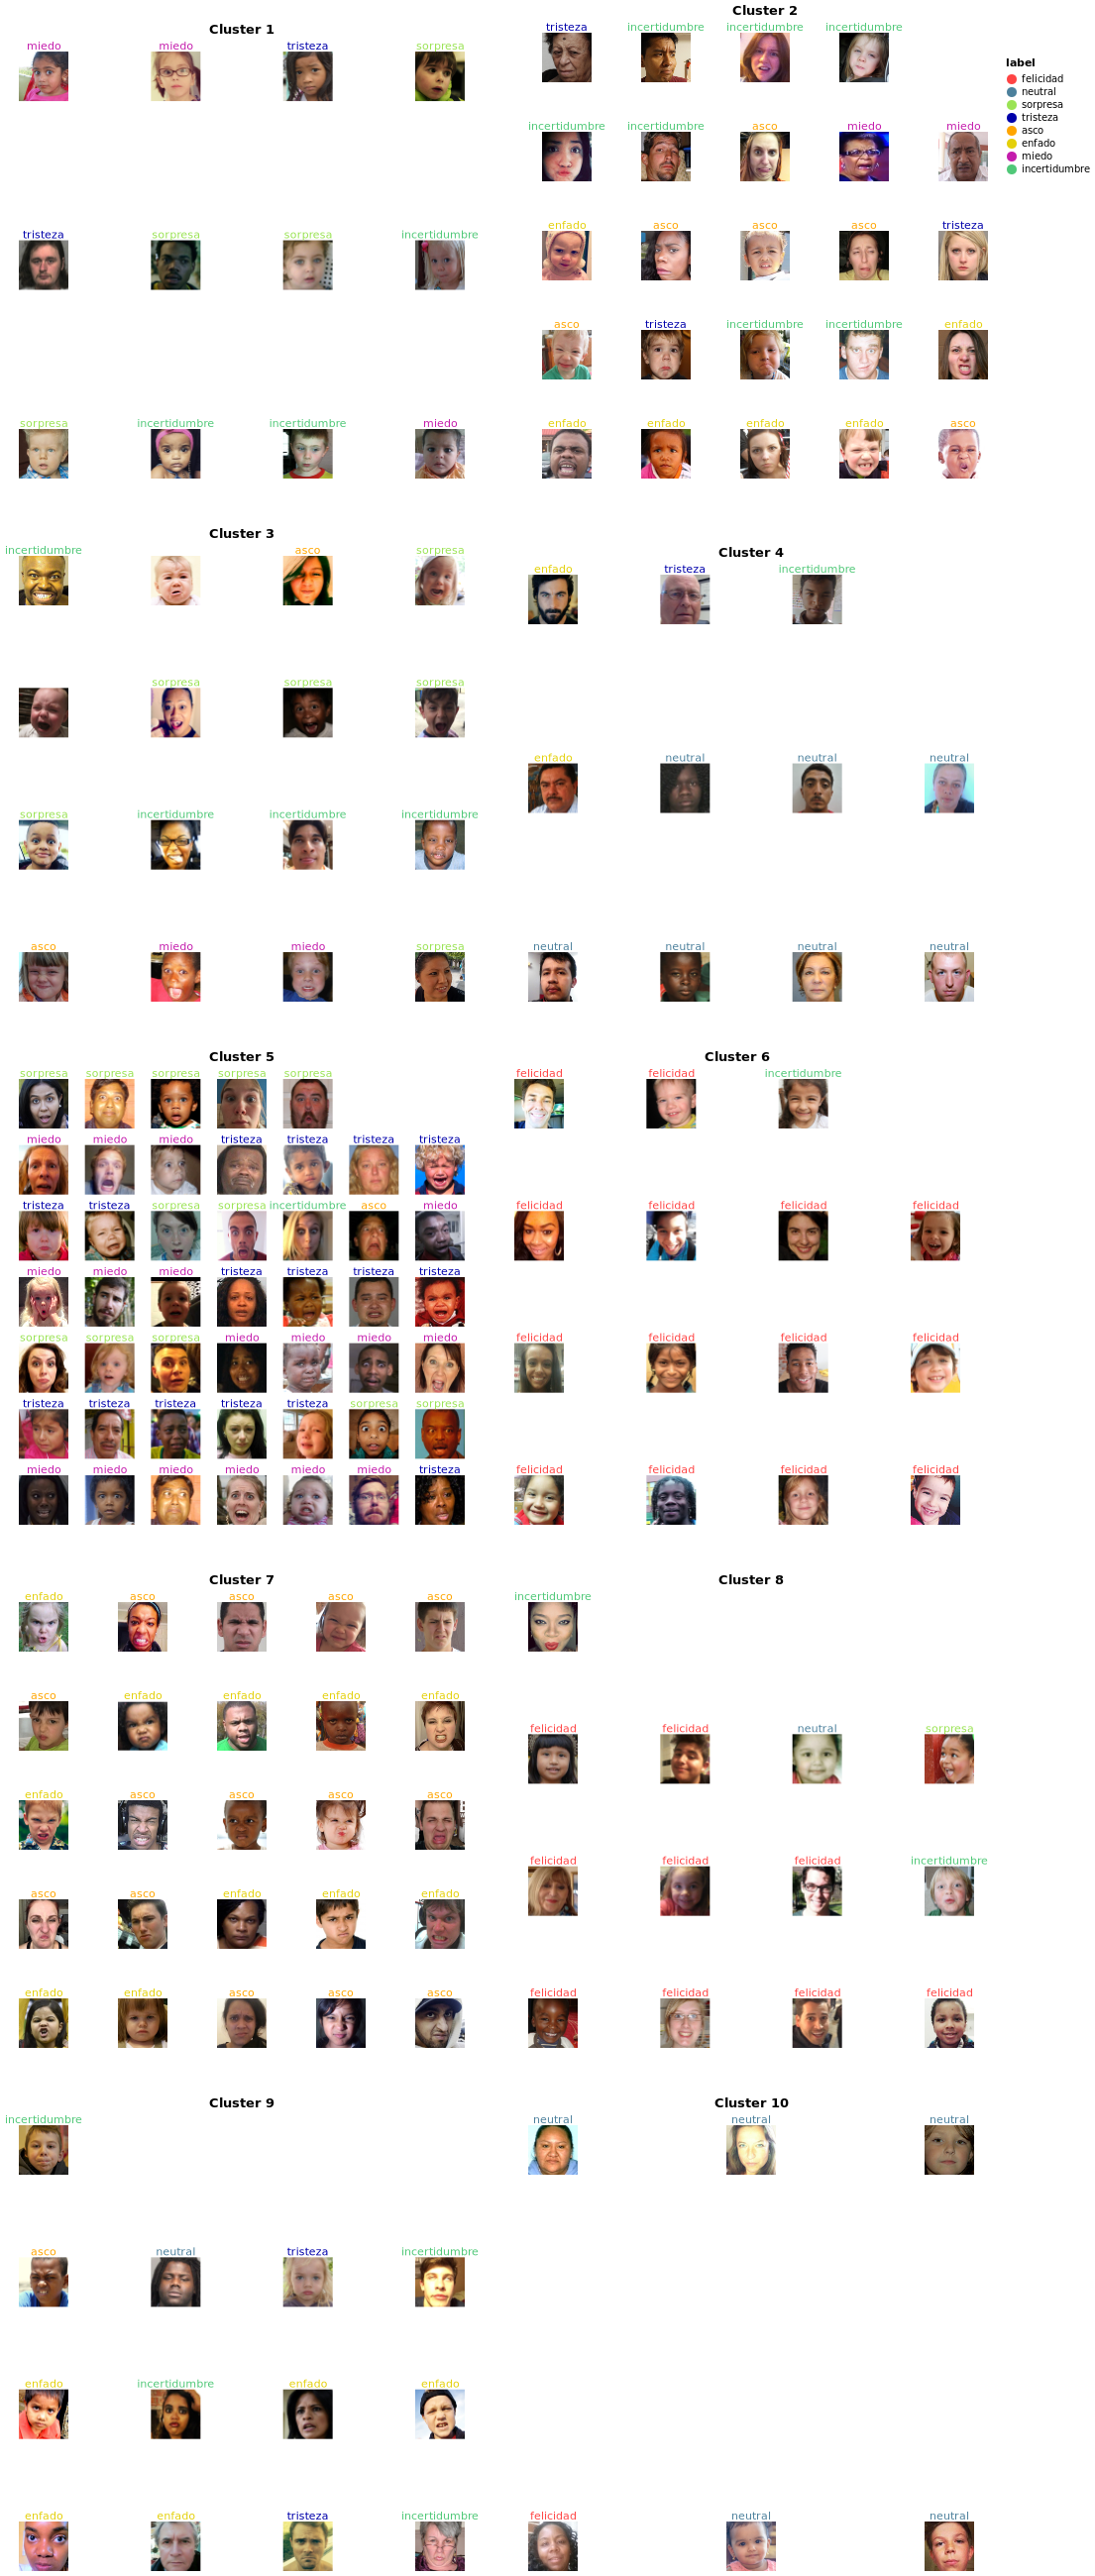

In [105]:
Image(filename='../data_mturk_espanol/k_means_free_choice_10_mturk_espanol.png') 

In [106]:
images_strings = pd.DataFrame({'image_title': image_title, 'svg': svg_str})

images_strings.to_csv('../clean_data_mturk_espanol/free_choice_svg_strings_mturk_espanol.csv', index=False)
images_strings.to_csv('../../emotions_dashboard/data/free_choice_svg_strings_mturk_espanol.csv', index=False)

df_svg = pd.read_csv('../clean_data_mturk_espanol/free_choice_svg_strings_mturk_espanol.csv')

df_svg['image_title']

0                            Participants by sex
1                            Participants by age
2                      Participants by ethnicity
3               Participants by formal education
4              Participants by country of origin
5         Overall results by expected label as %
6     Overall results by expected label as count
7                       Images depicting 'anger'
8                     Images depicting 'disgust'
9                        Images depicting 'fear'
10                   Images depicting 'surprise'
11                  Images depicting 'happiness'
12                    Images depicting 'sadness'
13        Images depicting 'uncertain (unknown)'
14                    Images depicting 'neutral'
15                          'anger' by ethnicity
16                        'disgust' by ethnicity
17                           'fear' by ethnicity
18                       'surprise' by ethnicity
19                      'happiness' by ethnicity
20                  